In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import lineagevi
import scanpy as sc
import scvelo as scv
import numpy as np
import os

In [44]:
adata = scv.datasets.pancreas()

In [45]:
adata.X = adata.layers['unspliced'].copy() + adata.layers['spliced'].copy()
adata.layers['counts'] = adata.X.copy()

In [46]:
lineagevi.utils.add_annotations(
    adata, 
    files=[file_path],
    min_genes=12,
    varm_key='I',
    uns_key='terms',
    clean=True,
    genes_use_upper=True)

adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)

In [47]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True, log=True)

Filtered out 8545 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [48]:
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=100)
sc.pp.neighbors(adata, n_neighbors=30)
scv.pp.moments(adata, n_neighbors=30)
sc.pp.scale(adata, layer='Mu')
sc.pp.scale(adata, layer='Ms')

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Filter out any annotations (terms) with less than 12 genes.

In [49]:
select_terms = adata.varm['I'].sum(0)>12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

Filter out genes not present in any retained terms after selection of HVGs.

In [50]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [51]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=20 + 1, metric='euclidean', n_jobs=-1)
nbrs.fit(adata.obsm['X_pca'])
distances, indices = nbrs.kneighbors(adata.obsm['X_pca'])

adata.uns['indices'] = indices

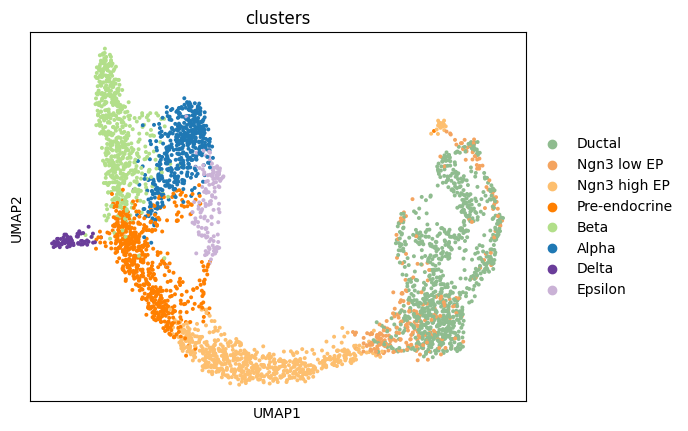

In [52]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='clusters')

In [ ]:
model = lineagevi.LineageVI(
    adata=adata,
    n_hidden=128,
    mask_key='I',
    unspliced_key='Mu',
    spliced_key='Ms',
    latent_key='z',
    nn_key='indices',
)

history = model.fit(
    K=10,
    batch_size=1024,
    lr=1e-3,
    epochs1=50,
    epochs2=50,
    seeds=(0, 1, 2),
    output_dir='/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas',   # or None
    verbose=1,
)

[Regime1] Epoch 1/50 - Loss: 3.1184
[Regime1] Epoch 2/50 - Loss: 3.0746
[Regime1] Epoch 3/50 - Loss: 3.0132
[Regime1] Epoch 4/50 - Loss: 2.9253
[Regime1] Epoch 5/50 - Loss: 2.8106
[Regime1] Epoch 6/50 - Loss: 2.6761
[Regime1] Epoch 7/50 - Loss: 2.5326
[Regime1] Epoch 8/50 - Loss: 2.3972
[Regime1] Epoch 9/50 - Loss: 2.2774
[Regime1] Epoch 10/50 - Loss: 2.1725
[Regime1] Epoch 11/50 - Loss: 2.0807
[Regime1] Epoch 12/50 - Loss: 1.9995
[Regime1] Epoch 13/50 - Loss: 1.9269
[Regime1] Epoch 14/50 - Loss: 1.8606
[Regime1] Epoch 15/50 - Loss: 1.8009
[Regime1] Epoch 16/50 - Loss: 1.7460
[Regime1] Epoch 17/50 - Loss: 1.6960
[Regime1] Epoch 18/50 - Loss: 1.6498
[Regime1] Epoch 19/50 - Loss: 1.6080
[Regime1] Epoch 20/50 - Loss: 1.5693
[Regime1] Epoch 21/50 - Loss: 1.5340
[Regime1] Epoch 22/50 - Loss: 1.5016
[Regime1] Epoch 23/50 - Loss: 1.4705
[Regime1] Epoch 24/50 - Loss: 1.4418
[Regime1] Epoch 25/50 - Loss: 1.4146
[Regime1] Epoch 26/50 - Loss: 1.3889
[Regime1] Epoch 27/50 - Loss: 1.3647
[Regime1] 

In [56]:
model.get_model_outputs(
    adata=adata,
    n_samples=100,
    return_mean=True,
    return_negative_velo=True,
    base_seed=0,
    save_to_adata=True,
    unspliced_key='Mu',
    spliced_key='Ms',
    latent_key='z',
    nn_key='indices'
)

computing velocity graph (using 1/10 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lgolinelli/miniconda3/envs/test1/lib

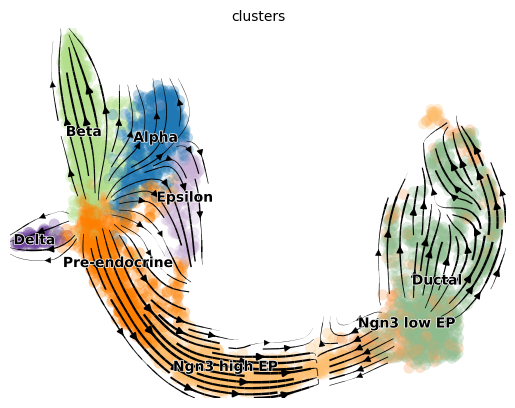

In [57]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color='clusters')

In [59]:
adata_gp = lineagevi.utils.build_gp_adata(
    adata,
    model=model,
    n_samples=100,
    return_negative_velo=True,
    base_seed=0
)

In [60]:
adata_gp

AnnData object with n_obs × n_vars = 3696 × 689
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    obsm: 'X_umap'
    layers: 'Ms', 'z', 'logvar', 'velocity'

computing velocity graph (using 1/10 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/lgolinelli/miniconda3/envs/test1/lib/python3.11/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


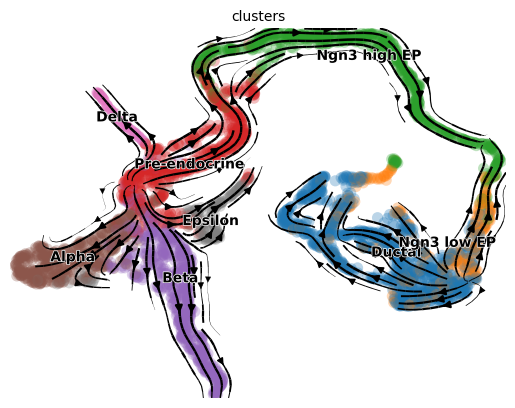

In [62]:
sc.pp.neighbors(adata_gp)
sc.tl.umap(adata_gp)
scv.tl.velocity_graph(adata_gp)
scv.pl.velocity_embedding_stream(adata_gp, color='clusters')

In [ ]:
linvi.map_velocities(
    adata,
    direction="gp_to_gene",
    n_samples=100,
    scale=10.0,
    velocity_key="velocity_gp2gene",
    return_gp_adata=False
)

map velocities should take in input both original anndata as well as adata_gp when in modality gene_to_gp so it can write the velocity cleanly.

i also think, except for uncertainty estimation, all other methods should simply work with the velocity (e.g. n samples) that 
was obtained from get model outputs

In [ ]:
gp_adata = linvi.map_velocities(
    adata,
    direction="gene_to_gp",
    n_samples=100,
    scale=10.0,
    velocity_key="velocity_gene2gp",
    return_gp_adata=True,
    return_negative_velo=True
)